In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

import statsmodels.api as sm
from patsy import dmatrices

Populating the interactive namespace from numpy and matplotlib


## Q1

I had trouble reading the file until I finally clicked the "raw" button on the up-right and the txt file finally looks normal. Seems Github did some "fancy" work to make the txt file look better but much harder to read in. Then I find different columns in the text file are seperated with tab(or double space), so setting delim_whitespace = True helps me seperate the column.

In [2]:
gold = pd.read_csv("https://raw.githubusercontent.com/ipeirotis/Get-Another-Label/master/data/AdultContent2/gold.txt",delim_whitespace = True, header=None, names = ['url','category'])
len(gold)
gold[:10]

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X
5,http://3x-pix.com,X
6,http://4d.com,G
7,http://4neurons.com,G
8,http://4-panama-city-beach-condo.com/index.htm,G
9,http://4whw.8m.net/,X


In [3]:
labels = pd.read_csv("https://raw.githubusercontent.com/ipeirotis/Get-Another-Label/master/data/AdultContent2/labels.txt",delim_whitespace = True, header=None, names = ['turk','url','category'])
len(labels)
labels[:10]

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
6,A31Z3E5SLATLML,http://000.cc,P
7,AAVCPZ8WTCFVK,http://000.cc,G
8,AHY98D5P05XIV,http://000.cc,G
9,APTFS1S88K5VC,http://000.cc,G


## Q2

I use merge function from pandas to get the laels_on_gold dataset, by setting "url" column as merge column, and just keep those "url" rows that showed in both gold and labels dataframe. Then the rest rows should be included in labels_unknown.

In [4]:
#use merge function to get the labels_on_gold dataframe, default setting for merge function is using the intersection of keys from both frames  
merged = pd.merge(gold,labels,
                  on = 'url',
                  suffixes=('_gold', '_label'))

#adjust the sequence of the column
labels_on_gold = merged[['turk','url','category_label']]
labels_on_gold.columns = ['turk','url','category']

#labels_unknown is just the rows in labels dataframe but not in labels_on_gold
labels_unknown = labels.loc[~labels['url'].isin(labels_on_gold['url'])]
labels_unknown.columns = ['turk','url','category']

labels_on_gold[:10]
labels_unknown[:10]

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
6,A31Z3E5SLATLML,http://000.cc,P
7,AAVCPZ8WTCFVK,http://000.cc,G
8,AHY98D5P05XIV,http://000.cc,G
9,APTFS1S88K5VC,http://000.cc,G


## Q3

Here since we are working on gold set urls, I just get the 'turk' column of rater_goodness from labels_on_gold dataframe, dropped duplicated to get unique 'turk' list and set 'turk' as index.

Then to get the number of ratings for each turk, I use groupby on the labels_on_gold dataframe. For the average correctness, since I have got a merged dataframe in Q2 where I get both the real category and the category given by turks, I created a mask from the merged dataframe to calculate the average correctness.

In the end I added the avg_correctness column to the rater_goodness dataframe to finish this question.

In [5]:
#Get rater_goodness DataFrame from labels_on_gold. The dataframe should have unique 'turk' and is indexed by turk
rater_goodness = pd.DataFrame(labels_on_gold['turk'])
rater_goodness = rater_goodness.drop_duplicates().set_index('turk')

#use groupby to get the number of ratings for each turk, the 'category' column is what we need in rater_goodness
turk_group = labels_on_gold.groupby('turk').count()
rater_goodness['num_of_ratings'] = turk_group['category']

#calculate the average correctness of each turk with a mask applied on the numerator. Make the avg_correctness a dataframe for next step.
mask_correct_rating = merged['category_gold'] == merged['category_label']
avg_correctness = merged['turk'][mask_correct_rating].value_counts()/merged['turk'].value_counts()
df_avg_correctness=pd.DataFrame(avg_correctness.fillna(0))
df_avg_correctness.columns = ['avg_correctness']

#concatenate the two dataframe to get all the info we need.
rater_goodness = pd.concat([rater_goodness, df_avg_correctness], axis=1)
rater_goodness[:10]

,num_of_ratings,avg_correctness
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
A13CEW9JGDWGX1,1,1.000000
A13OE9GBRJ0S2U,4,0.750000
A14IQ4GLNWNPOJ,1,1.000000
A153PKAL7OAY36,148,0.722973
A1554ZM0CLKSG5,1,1.000000


## Q4

calculate the odds based on given formula.

In [6]:
rater_goodness['odds'] = rater_goodness['avg_correctness']/(1.001-rater_goodness['avg_correctness'])
rater_goodness[:5]

,num_of_ratings,avg_correctness,odds
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251


## Q5

First get a mask to filter out turks who have rated at least 20 gold set URLs, then use sort_values to get the top 10 most accurate turks. I use index.get_values() to get only the turk info.

In [7]:
accurate_turks= rater_goodness[rater_goodness['num_of_ratings'] >= 20].sort_values('avg_correctness',ascending=False)[:10]
accurate_turks.index.get_values()

array(['A2U0R4X38GUKZE', 'A22C0PJUBFJTI0', 'A23YQUBXZPKILZ',
       'ATVALOQVDCMZW', 'A1HIXWH4OXT8S4', 'A3220HG1O83HQ4',
       'A32W20KGQXS0LL', 'A20PWAB7G3HDHU', 'AJSJVK40F5HM6',
       'A31OCN4MNHUQ6W'], dtype=object)

## Q6

To find out whether the number of ratings and the accuracy are correlated, I runned a linear regression model with number of ratings as independent variable and acg_correctness as dependent variable. I also plotted the relationship out. We can see from the graph that seems the two variables are not correlated, and the model summary also proves the same thing. The fitted model has got a very small coefficient with a very large p value, and 0 is in the coefficient confidence interval. R squared is also very small.

                            OLS Regression Results                            
Dep. Variable:        avg_correctness   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Tue, 02 Aug 2016   Prob (F-statistic):              0.459
Time:                        17:37:40   Log-Likelihood:                -94.663
No. Observations:                 269   AIC:                             193.3
Df Residuals:                     267   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.6431      0.024     27.

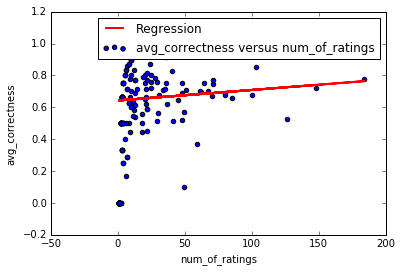

In [8]:
y, X = dmatrices('avg_correctness ~ num_of_ratings', data=rater_goodness, return_type='dataframe')
y[:3]
X[:3]
model = sm.OLS(y, X) # Set up the model
result = model.fit() # Fit model (find the intercept and slopes)
print result.summary()

x = rater_goodness['num_of_ratings']
y_actual = rater_goodness['avg_correctness']
y_expected = result.params['Intercept'] + result.params['num_of_ratings'] * x
scatter(x=x, y=y_actual, label='avg_correctness versus num_of_ratings')
plot(x, y_expected, color='red', linewidth=2, label='Regression')
xlabel('num_of_ratings')
ylabel('avg_correctness')
legend(loc='best')

###seems that the number of ratings by a turker on gold set URLs is not related to his or her accuracy.
###at least not linear related. From plot seems no other kinds of relationship as well
###small coefficient, large p value, 0 is in the coefficient confidence interval

## Q7

To solve this problem, I first filtered out the top 25th percentile of Turks from the rater_goodness dataframe, and use index.get_value get a list of these turks who fulfilled the requirement (b). Then I defined a function and map it to the labels_unknown dataframe to get those records with turks who have rated more gold set urls than 75% of all turks. Then I merged this sub-dataframe from labels_unknown with the sub-dataframe from rater_goodness on 'turk' to get the corresponding odds information.

then within that it's almost like a pivot table with urls as the index and the columns are the ratings and the product of the odds are the values. Then the groupby function can help us get the product of odds for all pair(u,c).

In [9]:
#check whether the turk have rated more gold set urls than 75% of all turks.
percentile75 = rater_goodness.sort_values(by = 'num_of_ratings',ascending = False).quantile(0.75)['num_of_ratings']
percentile75_turks_df = rater_goodness[rater_goodness['num_of_ratings']>percentile75]
percentile75_turks = percentile75_turks_df.index.get_values()
len(percentile75_turks)

def check_percentile75_turks(n):
    return n in percentile75_turks

labels_unknown_percentile75_turks_df = labels_unknown[labels_unknown['turk'].map(check_percentile75_turks)]
percentile75_turks_df = percentile75_turks_df.reset_index().rename(columns = {'index':'turk'})

merged_75 = labels_unknown_percentile75_turks_df.merge(percentile75_turks_df, 
                                                      on = 'turk',
                                                      how = 'inner') 

overall_odds = merged_75.groupby(["url", "category"])[["odds"]].prod()
len(overall_odds)
overall_odds

odds
url                                                category            
http://0-101.net                                   G           2.155963
http://000.cc                                      G           1.460583
http://0000.jp                                     G          14.488244
http://000relationships.com                        G           5.681060
                                                   P           1.851852
http://000vitamins.com                             G           3.784982
http://000webhost.com                              G          11.159502
http://003my.com                                   G           4.912040
http://007absolutehardcore.com/early_cumshots/i... P           3.346522
                                                   R          12.290450
                                                   X         293.252871
http://007swz.cn                                   G           1.393883
http://01768.com                                   G           1.393883
http://0198.cc                                     G           2.947446
http://01house.cn                                  G           3.874200
http://01net.com                                   G           2.463388
http://01yyy.com                                   G           3.874200
                                                   R           1.304682
http://020dna.com                                  G           5.054597
                                                   R           1.620746
http://020hp.net                                   G           2.463388
http://020shenghuo.com                             G           1.393883
http://021cd.com                                   G           3.378660
http://024haha.cn                                  G           1.460583
http://028114.com                                  G           1.854185
http://028town.com                                 G           3.626269
http://029bus.cn                                   G           1.097994
                                                   P           1.330229
http://029zp.com                                   G           1.047852
http://02et.cn                                     G           2.581266
...                                                                 ...
http://zoomerang.com                               G           6.271191
http://zoominfo.com                                G          50.648819
http://zoosk.com                                   G           1.818574
                                                   P           1.620746
http://zoower.com                                  G           6.796445
http://zooz.vn                                     G           4.350366
http://zoozle.org                                  G          33.942585
http://zorkabiz.ru                                 G           5.054597
http://zouri.jp                                    G           1.432532
http://zoznam.sk                                   G           2.652501
                                                   R           2.988048
http://zqt9.com                                    G           2.912430
http://zses.com                                    G           2.784941
http://zshare.net                                  G           2.423919
http://zshareblog.com                              G           1.097994
http://zsmhl.com                                   G           2.419121
                                                   P           1.620746
http://ztomy.com                                   G          16.420733
http://zucaiba.com                                 G           1.432532
http://zumin-ads.com                               G           2.779429
http://zune.net                                    G          20.209842
http://zvezdanews.ru                               G           5.831416
http://zwame.pt                                    G           8.623790
http://zwinky.com                  

## Q8

To get information from the groupby result, we first need to unstack it. And since we can need to find the maximum odd value of each row and we only apply functions to column, I first transpose the dataframe and then use the idxmax() and max() to get the top category and top odds. Then I find the top category I got now all have "odds" in front of the real category, so I defined a function to leave just the real category.

In [10]:
result_75 = pd.DataFrame(overall_odds.unstack().T.idxmax(),columns = ['top_category'])

def get_top_category(s):
    return s[1]

result_75['top_category'] = result_75['top_category'].map(get_top_category)
result_75['top_odds'] = overall_odds.unstack().T.max()
result_75


,top_category,top_odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883


## Q9

First I did everything in Q7 and Q8 again for top 75 percentile turks to get result_25. Then I merged result_25 and result_75 and use crosstab function to solve the problem.

In [11]:
percentile25 = rater_goodness.sort_values(by = 'num_of_ratings',ascending = False).quantile(0.25)['num_of_ratings']
percentile25_turks_df = rater_goodness[rater_goodness['num_of_ratings']>percentile25]
percentile25_turks = percentile25_turks_df.index.get_values()
len(percentile25_turks)

def check_percentile25_turks(n):
    return n in percentile25_turks

labels_unknown_percentile25_turks_df = labels_unknown[labels_unknown['turk'].map(check_percentile25_turks)]
percentile25_turks_df = percentile25_turks_df.reset_index().rename(columns = {'index':'turk'})

merged_25 = labels_unknown_percentile25_turks_df.merge(percentile25_turks_df, 
                                                       on = 'turk',
                                                       how = 'inner') 
merged_25

overall_odds_25 = merged_25.groupby(["url", "category"])[["odds"]].prod()

overall_odds_25

overall_odds_25.unstack().T.idxmax()  
result_25 = pd.DataFrame(overall_odds_25.unstack().T.idxmax(),columns = ['top_category'])
result_25

def get_top_category(s):
    return s[1]

result_25['top_category'] = result_25['top_category'].map(get_top_category)
result_25
result_25['top_odds'] = overall_odds.unstack().T.max()
result_25   

merged_25_75 = pd.merge(result_25,result_75,
                        left_index=True,
                        right_index=True,
                        suffixes=('_25', '_75'))
merged_25_75

most_error = pd.crosstab(merged_25_75['top_category_25'],merged_25_75['top_category_75'])
most_error

top_category_75,G,P,R,X
top_category_25,,,,
G,8327,189,21,27
P,574,328,34,6
R,186,47,128,26
X,216,19,25,457
